# MNIST \~\~\~My Best Version\~\~\~
This is a notebook which classified MNIST by using google colaboratory.<br>
Test accuracy was 99.69%.<br>
## Summary
* Accelerator: GPU
* Data Augmentation: Random Rotation, Parallel Translation, Random Zoom
* Model: Residual Block x3 - GAP - Dropout - Dense - Dropout - Dense
* Training: epochs<=50, batch_size=64, optimizer=Adam, Reduce Learning Rate

Mount My Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

work_dir = "/content/drive/My Drive/Colab Notebooks/mnist/"

Mounted at /content/drive


Import modules

In [ ]:
!pip install visualkeras
from visualkeras import layered_view

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.layers import add, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

print('tensorflow varsion:', tf.__version__)
print(tf.test.gpu_device_name())

tensorflow varsion: 2.4.1
/device:GPU:0


# Load and check data

Load data

In [ ]:
classes = [str(i) for i in range(10)]
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Check data

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0, 255, 0, 255)

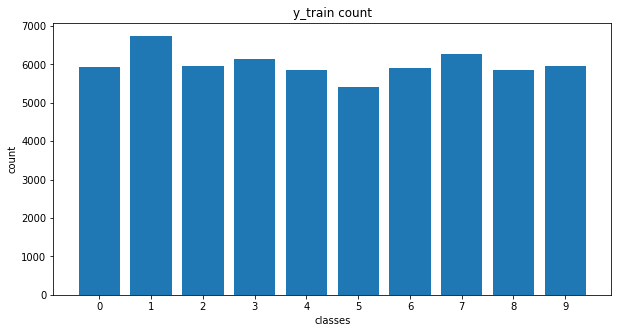

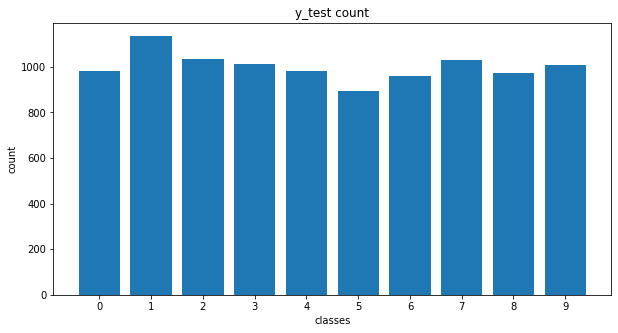

In [ ]:
def plot_count(y, classes=None, title='y count'):
    plt.figure(figsize=(10,5))
    counter_y = [(key, value) for key, value in Counter(y).items()]
    counter_y.sort(key=lambda x: x[0])
    if classes is None:
        classes = [key for key, value in counter_y]
    values = [value for key, value in counter_y]
    plt.bar(classes, values)
    plt.xlabel('classes')
    plt.ylabel('count')
    plt.title(title)
    plt.show()

plot_count(y_train, classes, title='y_train count')
plot_count(y_test, classes, title='y_test count')

In [ ]:
# show 10 images
def show_images(X, y_true=np.zeros(10), y_pred=None, classes=defaultdict(str)):
    plt.figure(figsize=(10,5))
    for i in range(min(10, X.shape[0], y_true.shape[0])):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # plot image
        try:
            plt.imshow(X[i], cmap=plt.cm.binary)
        except:
            plt.imshow(np.reshape(X[i],(X.shape[1],X.shape[2])), cmap=plt.cm.binary)

        # show y_true
        label = ''
        if len(y_true.shape) == 1:
            label += classes[y_true[i]]
        elif len(y_true.shape) == 2:
            label_rate = np.argsort(y_true[i])[::-1]
            if y_true[i][label_rate[0]] > 0.99:
                label = classes[label_rate[0]]
            else:
                label += classes[label_rate[0]] + ': ' + f'{y_true[i][label_rate[0]]:.2f}'
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_true[i][label_rate[1]]:.2f}'
                
        # show y_pred
        if y_pred is None:
            plt.xlabel(label)
            continue

        plt.ylabel('Answer: ' + label)
        label = 'Prediction\n'
        if len(y_pred.shape) == 1:
            label += classes[y_pred[i]]
        elif len(y_pred.shape) == 2:
            label_rate = np.argsort(y_pred[i])[::-1]
            label += classes[label_rate[0]] + ': ' + f'{y_pred[i][label_rate[0]]:.2f}'
            if y_pred[i][label_rate[1]] > 0.01:
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_pred[i][label_rate[1]]:.2f}'
        plt.xlabel(label)

    plt.show()

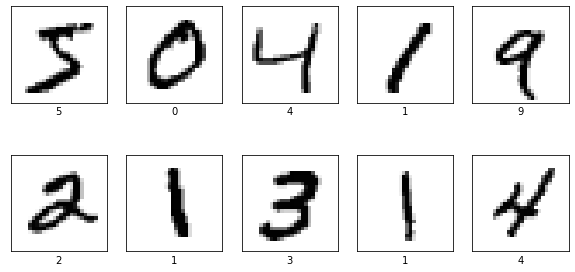

In [ ]:
show_images(X_train, y_train, classes=classes)

# Preprocess data

Normalize images

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, 0.0, 1.0)

Change shapes

In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

y_train = keras.utils.to_categorical(y_train, len(classes))
y_test = keras.utils.to_categorical(y_test, len(classes))

train_test_split

In [ ]:
validation_seed = 0
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=validation_seed)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)
(48000, 10) (12000, 10) (10000, 10)


# Augment images

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0.0)

Before Augmentation


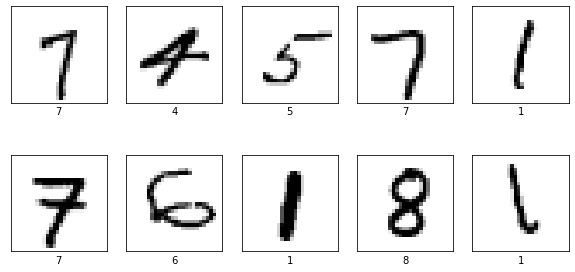

In [ ]:
print('Before Augmentation')
show_images(X_train, y_train, classes=classes)

After Augmentation


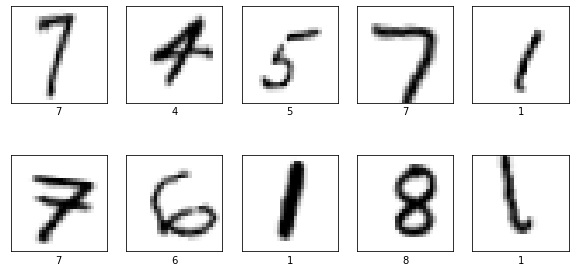

In [ ]:
print('After Augmentation')
show_images(datagen.flow(X_train[:10],batch_size=10,shuffle=False)[0], y_train, classes=classes)

In [ ]:
%%timeit -r 5
def measure_time(datagen_flow, steps):
    cnt = 0
    for X_aug, y_aug in datagen_flow:
        cnt += 1
        if cnt == steps:
            break

measure_time(datagen.flow(X_train, y_train, batch_size=64), steps=X_train.shape[0]//64)

1 loop, best of 5: 8.19 s per loop


# Create model

In [ ]:
def create_model(input_shape, len_classes):
    inputs = Input(input_shape)

    x = Conv2D(32, (3,3), activation='relu')(inputs)
    block_1_output = BatchNormalization()(x)

    x = Conv2D(32, (3,3), activation='relu', padding='same')(block_1_output)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x, block_1_output])
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    block_2_output = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(block_2_output)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x, block_2_output])
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    block_3_output = BatchNormalization()(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(block_3_output)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x, block_3_output])

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(len_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

model = create_model(input_shape=X_train[0].shape, len_classes=len(classes))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 26, 26, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   9248        batch_normalization[0][0]        
______________________________________________________________________________________________

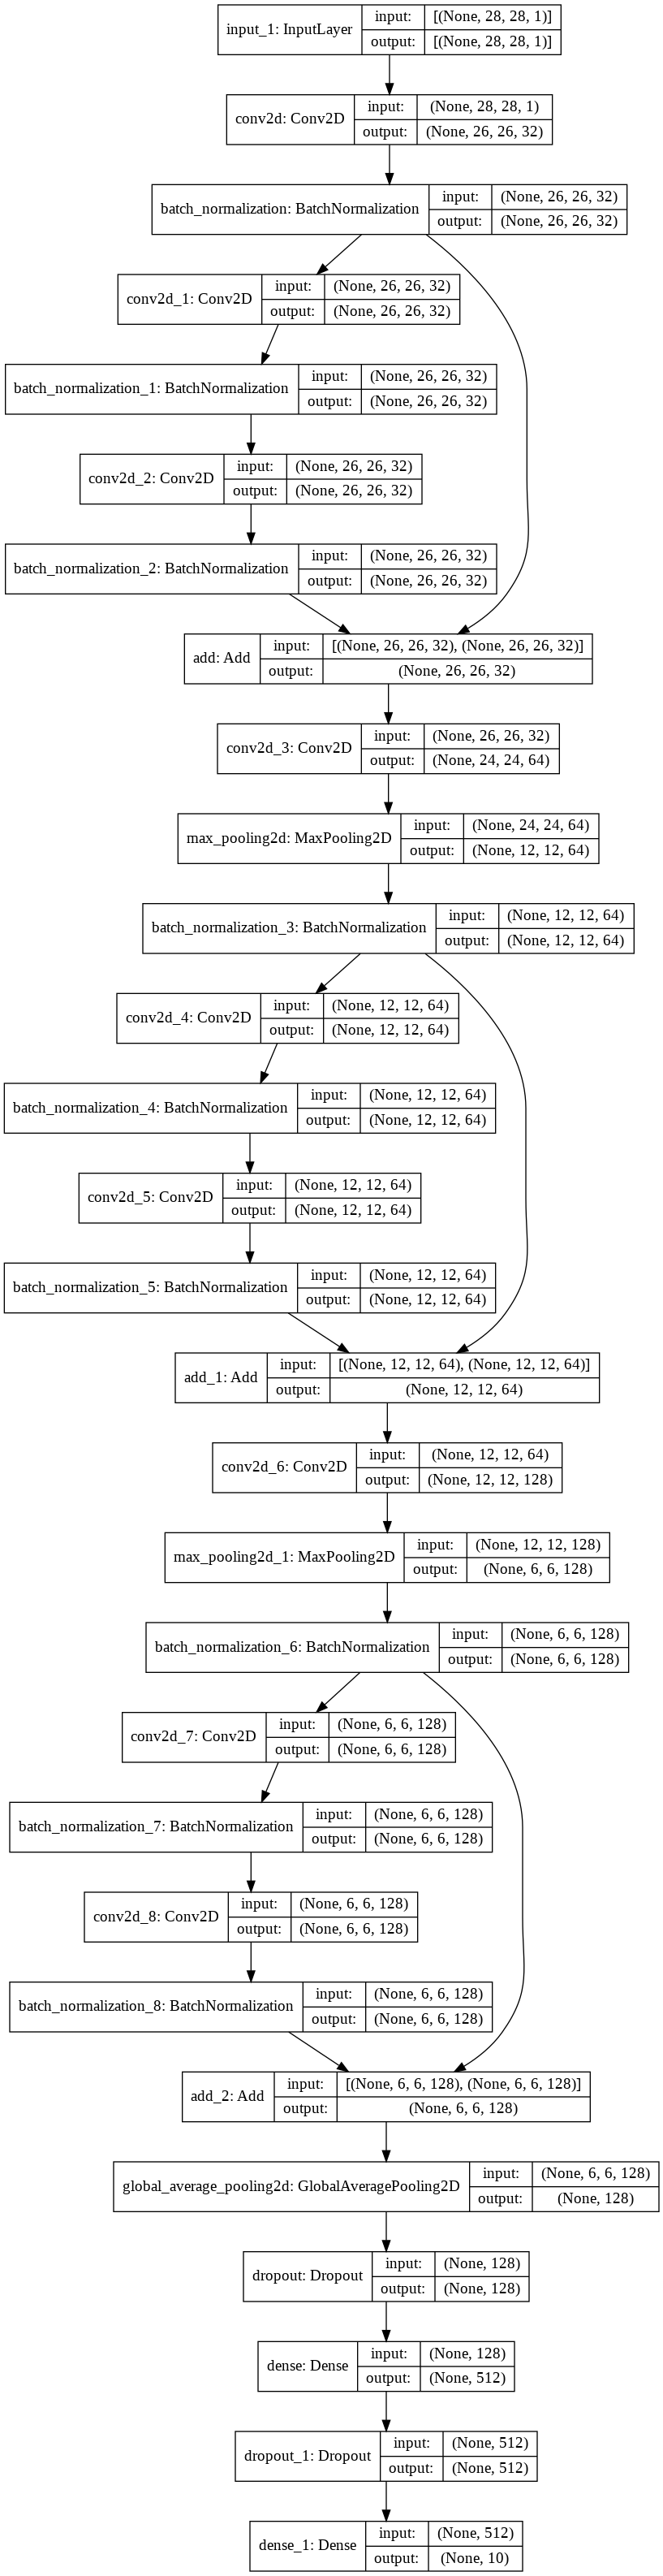

In [ ]:
plot_model(model, show_shapes=True)

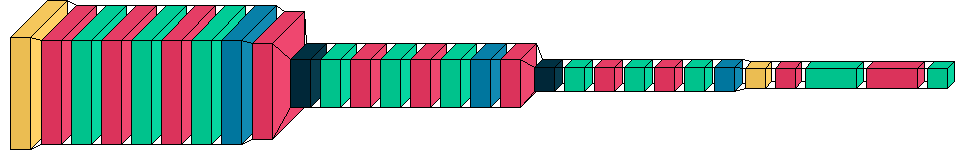

In [ ]:
layered_view(model)

# Train model

In [ ]:
weights_file_name = "best_weights(seed={}).hdf5".format(validation_seed)
model_file_name = "best_model(seed={}).h5".format(validation_seed)

In [ ]:
%%time

save_weights = ModelCheckpoint(filepath=os.path.join(work_dir, weights_file_name),
                                verbose=0, save_best_only=True, save_weights_only=True,
                                monitor='val_loss', mode='min')

early_stop = EarlyStopping(monitor='val_loss', mode='min',
                                patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min',
                                factor=0.5, patience=5, verbose=1)

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

batch_size = 64
epochs = 50

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    verbose=2,
                    callbacks=[save_weights, early_stop, reduce_lr])

model.save(os.path.join(work_dir, model_file_name))

Epoch 1/50
750/750 - 22s - loss: 0.1942 - accuracy: 0.9390 - val_loss: 0.0756 - val_accuracy: 0.9761
Epoch 2/50
750/750 - 13s - loss: 0.0716 - accuracy: 0.9786 - val_loss: 0.0617 - val_accuracy: 0.9822
Epoch 3/50
750/750 - 13s - loss: 0.0555 - accuracy: 0.9833 - val_loss: 0.0340 - val_accuracy: 0.9903
Epoch 4/50
750/750 - 13s - loss: 0.0486 - accuracy: 0.9858 - val_loss: 0.0324 - val_accuracy: 0.9905
Epoch 5/50
750/750 - 13s - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0296 - val_accuracy: 0.9914
Epoch 6/50
750/750 - 13s - loss: 0.0408 - accuracy: 0.9880 - val_loss: 0.0278 - val_accuracy: 0.9923
Epoch 7/50
750/750 - 13s - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.0269 - val_accuracy: 0.9927
Epoch 8/50
750/750 - 13s - loss: 0.0359 - accuracy: 0.9895 - val_loss: 0.0305 - val_accuracy: 0.9912
Epoch 9/50
750/750 - 13s - loss: 0.0355 - accuracy: 0.9892 - val_loss: 0.0197 - val_accuracy: 0.9944
Epoch 10/50
750/750 - 13s - loss: 0.0316 - accuracy: 0.9909 - val_loss: 0.0248 - val_accura

Plot history

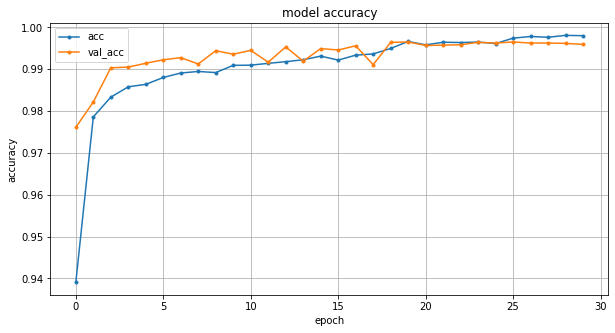

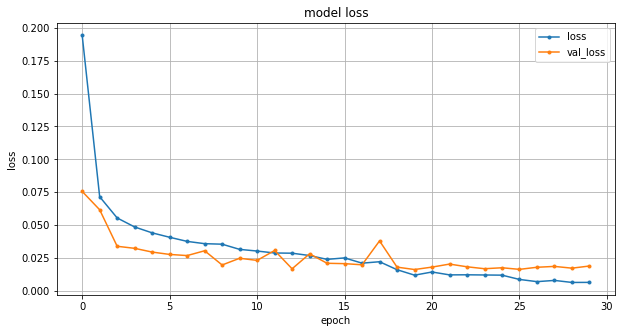

In [ ]:
def plot_history(history):
    # plot accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], marker='.', label='acc')
    plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
    plt.title('model accuracy')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

    # plot loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], marker='.', label='loss')
    plt.plot(history.history['val_loss'], marker='.', label='val_loss')
    plt.title('model loss')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

plot_history(history)

# Analyze validation results

In [ ]:
model = load_model(os.path.join(work_dir, model_file_name))
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
def calculate_loss_and_acc(y_test, y_pred):
    loss = np.average(categorical_crossentropy(y_test, y_pred))
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)
    acc = np.average(np.equal(y_test, y_pred))
    print('loss:', loss, 'acc:', acc)


def show_mistaken_images(X_test, y_test, y_pred, classes):
    miss_X = []
    miss_y_test = []
    miss_y_pred = []
    for i in range(y_test.shape[0]):
        if np.argmax(y_test[i]) != np.argmax(y_pred[i]):
            miss_X.append(X_test[i])
            miss_y_test.append(y_test[i])
            miss_y_pred.append(y_pred[i])
            if len(miss_X) == 10:
                break
    miss_X = np.array(miss_X)
    miss_y_test = np.array(miss_y_test)
    miss_y_pred = np.array(miss_y_pred)
    show_images(miss_X, miss_y_test, miss_y_pred, classes)


def plot_confusion_matrix(y_test, y_pred, classes):
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)

    cmx = confusion_matrix(y_test, y_pred)
    vmax = np.sort(np.ravel(cmx))[-len(classes)-1]
    cmx = pd.DataFrame(cmx, index=classes, columns=classes)

    plt.figure(figsize=(10,10))
    sns.heatmap(cmx, vmax=vmax, annot=True, square=True, cmap='Blues')
    plt.xlabel('prediction class')
    plt.ylabel('answer class')
    plt.title('confusion matrix')
    plt.show()

validation results
loss: 0.016292006 acc: 0.9965


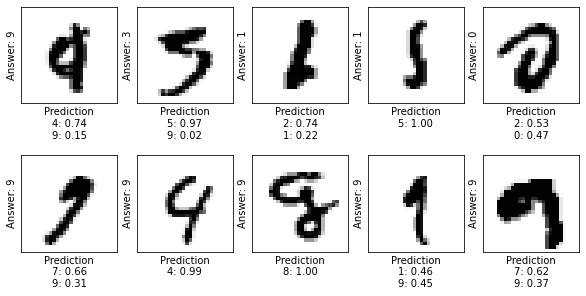

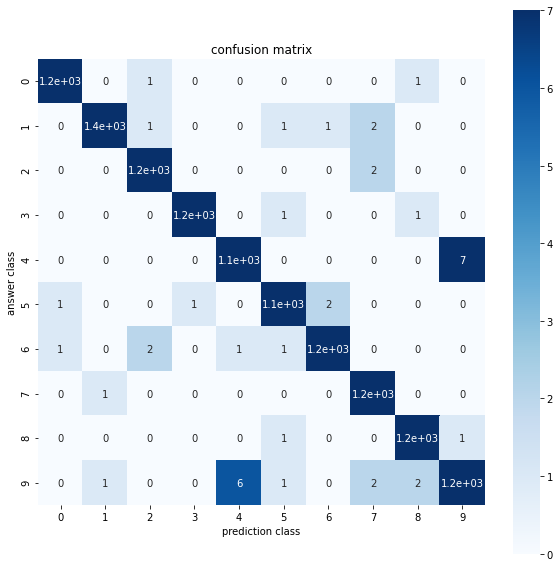

In [ ]:
print('validation results')
y_pred = model.predict(X_valid)
calculate_loss_and_acc(y_valid, y_pred)
show_mistaken_images(X_valid, y_valid, y_pred, classes)
plot_confusion_matrix(y_valid, y_pred, classes)

# Calculate test loss and accuracy

In [ ]:
print('test results')
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('loss:', loss, 'acc:', acc)

test results
loss: 0.0114701297134161 acc: 0.9969000220298767
